<a href="https://colab.research.google.com/github/seongcho1/mnetest/blob/main/eeg_motor_imagery_006_Transform_EEG_data_using_current_source_density_(CSD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transform EEG data using current source density (CSD)
This script shows an example of how to use CSD [1][2][3][4]. CSD takes the spatial Laplacian of the sensor signal (derivative in both x and y). It does what a planar gradiometer does in MEG. Computing these spatial derivatives reduces point spread. CSD transformed data have a sharper or more distinct topography, reducing the negative impact of volume conduction.

https://mne.tools/stable/auto_examples/preprocessing/muscle_ica.html

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.0 MB/s eta 0:00:00


In [23]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

event_id = dict(hands=2, feet=3)  # motor imagery: hands vs feet
subject = 1
#runs = [6, 10, 14]
#runs = [1, ]
runs = [6,]

raw = mne.io.read_raw_edf(
    mne.datasets.eegbci.load_data(subject=subject, runs=runs)[0], preload=True)

mne.datasets.eegbci.standardize(raw)  # set channel names
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
#raw.filter(l_freq=1., h_freq=None)


raw = raw.pick_types(meg=False, eeg=True, eog=True, ecg=True, stim=True,
                     #exclude=raw.info['bads']
                     ).load_data()
events = mne.events_from_annotations(raw)
#events = mne.find_events(raw)
raw.set_eeg_reference(projection=True).apply_proj()


Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

Plot the raw data and CSD-transformed raw data:

Fitted sphere radius:         95.5 mm
Origin head coordinates:      -0.8 14.9 44.4 mm
Origin device coordinates:    -0.8 14.9 44.4 mm
Using matplotlib as 2D backend.


/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


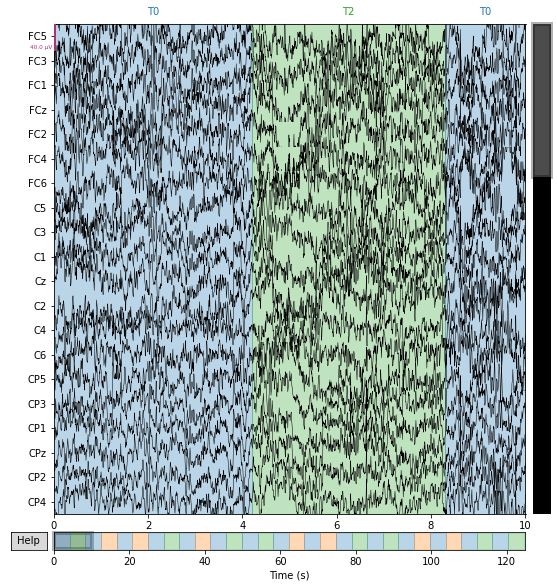

/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


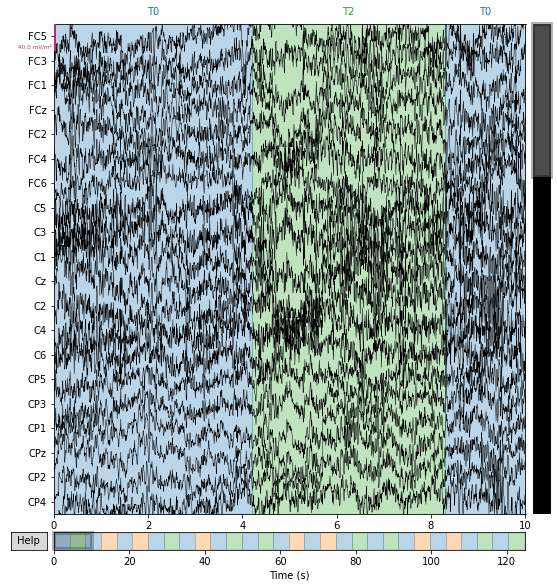

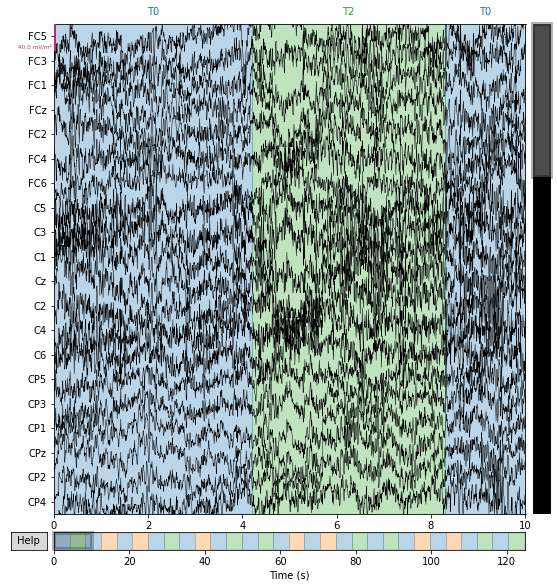

In [5]:
raw_csd = mne.preprocessing.compute_current_source_density(raw)
raw.plot()
raw_csd.plot()

Also look at the power spectral densities:

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)


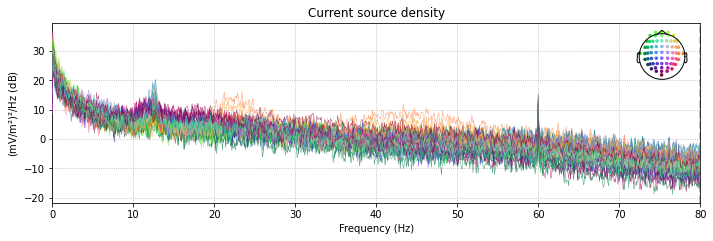

In [24]:
raw.plot_psd()
raw_csd.plot_psd()

CSD can also be computed on Evoked (averaged) data. Here we epoch and average the data so we can demonstrate that.

In [26]:
events = mne.events_from_annotations(raw)
events = [0,1,2]



Used Annotations descriptions: ['T0', 'T1', 'T2']


In [28]:
event_id = {'T0':0, 'T1':1, 'T2':2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=-0.2, tmax=.5,
                    preload=True)
evoked = epochs['T1'].average()

ValueError: ignored

In [30]:
epochs

NameError: ignored

First let’s look at how CSD affects scalp topography:

In [29]:
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')

NameError: ignored

CSD has parameters stiffness and lambda2 affecting smoothing and spline flexibility, respectively. Let’s see how they affect the solution:

In [21]:
fig, ax = plt.subplots(4, 4)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 10)
for i, lambda2 in enumerate([0, 1e-7, 1e-5, 1e-3]):
    for j, m in enumerate([5, 4, 3, 2]):
        this_evoked_csd = mne.preprocessing.compute_current_source_density(
            evoked, stiffness=m, lambda2=lambda2)
        this_evoked_csd.plot_topomap(
            0.1, axes=ax[i, j], contours=4, time_unit='s',
            colorbar=False, show=False)
        ax[i, j].set_title('stiffness=%i\nλ²=%s' % (m, lambda2))

NameError: ignored